# Attention mechanism 

- Seq2Seq 모델의 문제점
    - Seq2Seq 모델은 Encoder에서 입력 시퀀스에 대한 특성을 **하나의 고정된 context vector**에 압축하여 Decoder로 전달 한다. Decoder는 이 context vector를 이용해서 출력 시퀀스를 만든다.
    - 하나의 고정된 크기의 vector에 모든 입력 시퀀스의 정보를 넣다보니 정보 손실이 발생한다.
    - Decoder에서 출력 시퀀스를 생성할 때 동일한 context vector를 기반으로 한다. 그러나 각 생성 토큰마다 입력 시퀀스에서 참조해야 할 중요도가 다를 수 있다.

- **Attention Mechanism 아이디어**
    -  Decoder에서 출력 단어를 예측하는 매 시점(time step)마다, Encoder의 입력 문장(context vector)을 다시 참고 하자는 것. 이때 전체 입력 문장의 단어들을 동일한 비율로 참고하는 것이 아니라, Decoder가 해당 시점(time step)에서 예측해야할 단어와 연관이 있는 입력 부분을 좀 더 집중(attention)해서 참고 할 수 있도록 하자는 것이 기본 아이디어이다.

- 다양한 Attention 종류들이 있다.
    -  Decoder에서 출력 단어를 예측하는 매 시점(time step)마다 Encoder의 입력 문장의 어느 부분에 더 집중(attention) 할지를 어떻게 계산하느냐에 따라 다양한 attention 방식이 있다.
    -  `dot attention - Luong`, `scaled dot attention - Vaswani`, `general  attention - Luong`, `concat  attention - Bahdanau` 등이 있다.

# DataLoading

In [1]:
import os
import numpy as np
import pandas as pd
import random

df = pd.read_csv('datasets/ChatbotData.csv')
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# 토큰화

In [2]:
question_texts = list(df['Q'])
answer_texts = list(df['A'])
all_texts = list(question_texts + answer_texts)
len(question_texts), len(answer_texts), len(all_texts)

(11823, 11823, 23646)

## 학습

In [3]:
import os
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

vocab_size = 30000

min_frequency = 1

tokenizer = Tokenizer(
    BPE(unk_token='[UNK]')
)

tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    vocab_size = vocab_size, 
    min_frequency = min_frequency,
    special_tokens = ["[PAD]", "[UNK]", "[SOS]", "[EOS]"],
)

tokenizer.train_from_iterator(all_texts, trainer=trainer)

In [4]:
print(tokenizer.get_vocab_size())
e = tokenizer.encode("안녕하세요. 즐거운 하루되세요")

26034


In [5]:
print(e.tokens)
print(e.ids)

['안녕하세요', '.', '즐거운', '하루', '되', '세요']
[5091, 9, 2283, 1435, 323, 1245]


In [6]:
tokenizer.decode([5091, 9, 2283, 1435, 323, 1245])

'안녕하세요 . 즐거운 하루 되 세요'

## 저장

In [7]:
##########################
os.makedirs('models/tokenizers', exist_ok=True)
tokenizer_path = 'models/tokenizers/chatbot_bpe.json'
tokenizer.save(tokenizer_path)

# Dataset 생성
- 한문장 단위로 학습시킬 것이므로 DataLoader를 생성하지 않고 Dataset에서 index로 조회한 질문-답변을 학습시킨다.

In [7]:
import random
import os
import time
import math

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Dataset 클래스 정의

In [8]:
class ChatbotDataset(Dataset):

    """
    Attribute
        max_length
        tokenizer: Tokenizer
        vocab_size: int - Tokenizer에 등록된 총 어휘수
        SOS: int - [SOS] 문장의 시작 토큰 id
        EOS: int = [EOS] 문장의 끝 토큰 id
        question_squences: list - 모든 질문 str을 token_id_list(token sequence) 로 변환하여 저장한 list 
        answser_sequences: list - 모든 답변 str을 token_id_list(token sequence) 로 변환하여 저장한 list.
    """
    def __init__(self, question_texts, answer_texts, tokenizer, min_length=3, max_length=25):
        """
        question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
        answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
        tokenizer: Tokenizer
        min_length=3: int - 최소 토큰 개수. 질문과 답변의 token수가 min_length 이상인 것만 학습한다.
        max_length=25:int 개별 댓글의 token 개수. 모든 댓글의 토큰수를 max_length에 맞춘다.
        """
        
        self.max_length = max_length  # 문장 구성 토큰의 최대개수.
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.get_vocab_size()
        self.SOS = self.tokenizer.token_to_id('[SOS]') # 문장 시작 토큰
        self.EOS = self.tokenizer.token_to_id('[EOS]') # 문장 끝 토큰
        
        self.question_squences = [] #[[200, 300, 250, ..], ....]
        self.answer_sequences = []
        for q, a in zip(question_texts, answer_texts):
            # q, a: string 
            q_tokens = self.__process_sequence(q) # str -> [200, 300, 250, ...]
            a_tokens = self.__process_sequence(a)
            # 토큰수가 min_length 초과인 질문-답변만 list에 추가.
            if len(q_tokens) > min_length and len(a_tokens) > min_length:
                self.question_squences.append(q_tokens)
                self.answer_sequences.append(a_tokens)
            

    def __add_special_tokens(self, token_sequence): #[20, 300, 25]
        """
        max_length 보다 token 수가 많은 경우 max_length-1에 맞춰 뒤를 잘라낸다. (-1: EOS 추가하기 위해.)
        token_id_list 에 [EOS] 토큰 추가. 
        """

        token_sequence = token_sequence[:self.max_length-1]
        token_sequence.append(self.EOS)
        
        return token_sequence
    
    def __process_sequence(self, text):
        """
        한 문장 string을 받아서 token_id 리스트(list)로 변환 후 반환
        """
        encode = self.tokenizer.encode(text)
        token_ids = self.__add_special_tokens(encode.ids)
        return token_ids
    
    def __len__(self):
        return len(self.question_squences)

    def __getitem__(self, index):    
        # self.question_squences[index] -> [token수] => [token수, 1]
        return torch.LongTensor(self.question_squences[index]).unsqueeze(1), torch.LongTensor(self.answer_sequences[index]).unsqueeze(1)

### Dataset 객체 생성

In [9]:
MAX_LENGTH = 25
MIN_LENGTH = 3
dataset = ChatbotDataset(question_texts, answer_texts, tokenizer, MIN_LENGTH, MAX_LENGTH)

In [11]:
a, b = dataset[0]
print(a.shape, b.shape)

torch.Size([4, 1]) torch.Size([5, 1])


In [12]:
a, b

(tensor([[13306],
         [  369],
         [    4],
         [    3]]),
 tensor([[4998],
         [ 379],
         [3868],
         [   9],
         [   3]]))

In [ ]:
# 한 문장씩 학습 -> DataLoader는 생성하지 않음.

# 모델

In [13]:
a

tensor([[13306],
        [  369],
        [    4],
        [    3]])

## Encoder
- seq2seq 모델과 동일 한 구조
    - 이전 코드(seq2seq)와 비교해서 forward()에서 입력 처리는 token 하나씩 하나씩 처리한다. 

![encoder](figures/attn_encoder-network_graph.png)

In [10]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        """
        Parameter
            num_vocabs: int - 총 어휘수 
            hidden_size: int - GRU의 hidden size
            embedding_dim: int - Embedding vector의 차원수 
            num_layers: int - GRU의 layer수
        """
        super().__init__()
        self.num_vocabs = num_vocabs # 총단어개수 
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        #Embedding Layer
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        #GRU Layer
        self.gru = nn.GRU(
            input_size=embedding_dim, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=False      # Encoder도 토큰 하나씩 순서대로 입력받아 처리. 단방향.
        )
        
    def forward(self, x, hidden):
        """
        한개 질문의 token 한개의 토큰 id를 입력받아 hidden state를 출력
        batch=1       seq_len=1
        Parameter
            x: 한개 토큰. shape-[1] ex) [3000]
            hidden: hidden state (이전 처리결과). shape: [1, 1, hidden_size] 
                                                              (layer수(1) * 단방향(1), batch(1), hidden_size)
        Return
            tuple: (output, hidden) - output: [1, 1, hidden_size],  hidden: [1, 1, hidden_size]
        """
        x = self.embedding(x).unsqueeze(0)  # (1, embedding_dim) -> (1**, 1, embedding_dim)
        output, hidden = self.gru(x, hidden)
        return output, hidden
    
    def init_hidden(self, device):
        """
        처음 입력할 hidden_state. 
        값: 0
        shape: (Bidirectional(1) x number of layers(1), batch_size: 1, hidden_size) 
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [30]:
a, b = dataset[0]
a

tensor([[13306],
        [  369],
        [    4],
        [    3]])

In [33]:
a[0]

tensor([13306])

In [18]:
vocab_size = 30000
embedding_dim = 100
hidden_size = 256

# Encoder 처리 로직
el = nn.Embedding(vocab_size, embedding_dim)
gru = nn.GRU(embedding_dim, hidden_size)

print(a[0].shape)
x = el(a[0])  # 입력: 한개 문장의 한개 토큰씩 입력.
print(x.shape)  # 1개, 100 Embedding vector
x = x.unsqueeze(0) # gru input shape에 맞추기 위해서. (seq_len, batch_size, input_size)
print(x.shape)   
# print(x)
init_hidden = torch.zeros(1, 1, hidden_size) # ==> encoder.init_hidden()
o1, h1 = gru(x, init_hidden)
print(o1.shape, h1.shape)

#  두번째 timestep grup
o2, h2 = gru(x, h1) # a[1] 토큰 embedding 값, 첫번째 timestep의 hidden state 처리결과.

torch.Size([1])
torch.Size([1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


## Attention 적용 Decoder
![seq2seq attention outline](figures/attn_seq2seq_attention_outline.png)

- Attention은 Decoder 네트워크가 순차적으로 다음 단어를 생성하는 자기 출력의 모든 단계에서 인코더 출력 중 연관있는 부분에 **집중(attention)** 할 수 있게 한다. 
- 다양한 어텐션 기법중에 **Luong attention** 방법은 다음과 같다.
  
![attention decoder](figures/attn_decoder-network_graph.png)

### Attetion Weight
- Decoder가 현재 timestep의 단어(token)을 생성할 때 Encoder의 output 들 중 어떤 단어에 좀더 집중해야 하는지 계산하기 위한 가중치값.
  
![Attention Weight](figures/attn_attention_weight.png)

### Attention Value
- Decoder에서 현재 timestep의 단어를 추출할 때 사용할 Context Vector. 
    - Encoder의 output 들에 Attention Weight를 곱한다.
    - Attention Value는 Decoder에서 단어를 생성할 때 encoder output의 어떤 단어에 더 집중하고 덜 집중할지를 가지는 값이다.

![attention value](figures/attn_attention_value.png)

### Feature Extraction
- Decoder의 embedding vector와 Attention Value 를 합쳐 RNN(GRU)의 입력을 만든다.
    - **단어를 생성하기 위해 이전 timestep에서 추론한 단어(현재 timestep의 input)** 와 **Encoder output에 attention이 적용된 값** 이 둘을 합쳐 입력한다.
    - 이 값을 Linear Layer함수+ReLU를 이용해 RNN input_size에 맞춰 준다. (어떻게 input_size에 맞출지도 학습시키기 위해 Linear Layer이용)

![rnn](figures/att_attention_combine.png)

### 단어 예측(생성)
- RNN에서 찾은 Feature를 총 단어개수의 units을 출력하는 Linear에 입력해 **다음 단어를 추론한다.**
- 추론한 단어는 다음 timestep의 입력($X_t$)으로 RNN의 hidden은 다음 timestep 의 hidden state ($h_{t-1}$) 로 입력된다.


In [11]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, 
                  dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        
        ## Attention Score를 만드는 Linear Layer. 이 결과를 Softmax를 통과시키면 Attention weight(distribution)
        self.attn = nn.Linear(
            in_features=hidden_size+embedding_dim, # 이전 timestep hidden_state + 현재입력 embedding vector
            out_features=max_length, # encoder hidden_state들에 곱해질 값을 출력. hidden_state의 개수==MAX_LENGTH
        )
        ## Attention Value + embedding vector를 입력으로 받아서 GRU 입력 크기로 줄여주는 역할.
        self.attn_combine = nn.Linear(
            hidden_size + embedding_dim, #attention value 와 embedding vector concat 한 크기.
            hidden_size,   # GRU input_size
        )
        self.gru = nn.GRU(
            input_size=hidden_size,   # 입력
            hidden_size=hidden_size # hidden state개수(Node/Unit/Neuron 수)
        )
        self.classifier = nn.Linear(
            in_features=hidden_size, 
            out_features=num_vocabs  # 각 단어가 생성할 단어일 확률 -> 총 단어의 개수.
        )
        self.dropout = nn.Dropout(dropout_p)
    

    def forward(self, x, hidden, encoder_outputs):
        """
        Parameter
            x: 현재 timestep의 입력 토큰 id
            hidden: 이전 timestep 처리결과 hidden state
            encoder_outputs: Encoder output들. 
        Return
            tuple: (output, hidden, attention_weight)
                output: 다음 단어일 단어별 확률.  shape: [vocab_size]
                hidden: hidden_state. shape: [1, 1, hidden_size]
                attention_weight: Encoder output 중 어느 단어에 집중해야하는 지 가중치값. shape: [1, max_length]
        
        현재 timestep 입력과 이전 timestep 처리결과를 기준으로 encoder_output와 계산해서  encoder_output에서 집중(attention)해야할 attention value를 계산한다.
        attention value와 현재 timestep 입력을 기준으로 단어를 추론(생성) 한다.
        """
        ######################################
        # Embedding
        ## input shape: [1] - 한문장의 단어 1개 (batch-1, seq_len-1)
        ## 출력 shape:  [1, embedding_dim]  -> seq_length dim을 추가. [1, 1, embedding_dim]
        ######################################
        embedding = self.embedding(x).unsqueeze(0)

        ################################################
        # Attention Weight 
        ##  embedding dropout 적용
        ##  hidden_state(이전 step) 와 embedding vector를 합치기.
        ##  attn(Linear) 통과시켜서 size를 줄이기.  ==> Attention Score
        ##  softmax(Attention Score) ==> Attention weight
        ################################################
        embedding = self.dropout(embedding)
        
        attn_in = torch.concat((embedding[0], hidden[0]), dim=1) #dim=1  -----> 방향으로 합친다.
        # (1, embedding_dim)  (1, hidden_size)  = (1, em + hs)
        attention_score = self.attn(attn_in)  # (1, max_length)
        attention_weights = nn.Softmax(dim=-1)(attention_score) #attention_score.sofmax(dim=-1)

        ################################################
        # Attention Value (Context Vector)계산
        ## attention_weight x encoder의 output들
        ################################################

        attention_value = torch.bmm(
            attention_weights.unsqueeze(0), # (1, max_length)              => (1, 1, max_legnth)
            encoder_outputs.unsqueeze(0)   # (max_length, hidden_size) =>(1, max_length, hidden_size)
        )  # attention_value shape:   (1, 1, hidden_size)
        # bmm() - batch_matrix_multiply (batch 행렬곱) => 1, 2 축 행렬끼리 행렬곱

        ################################################################
        # GRU에 입력할 값을 생성 -> GRU
        ## attention_value 와 decoder 입력 embedding vector를 concat
        ## concat 한 것을 GRU 입력 크기(hidden_size)  에 맞도록 Linear를 이용해 조절.
        ## ReLU로 비선형 처리
        ## GRU에 입력 (윗단계에서 처리한 값,  이전 timestep의 hidden state)
        ################################################################
        attn_combine_in = torch.concat(
            [attention_value[0], embedding[0]],  # [1, hidden_size] + [1, embedding_dim] => [1, h_s + e_d]
            dim=-1
        )
        gru_in = self.attn_combine(attn_combine_in) # 출력: [1, hidden_size]
        gru_in = gru_in.unsqueeze(0)  # [1, 1, hidden_size]
        gru_in = nn.ReLU()(gru_in)
        output, hidden = self.gru(gru_in, hidden)  
        ################################################################
        # output을 classifier에 입력해서 단어 추론(분류)
        ################################################################
        last_output = self.classifier(output[0])   #output: [1, 1, hidden] -> [1, hidden] -Linear-> [1, num_vocabs]

        # return: last_output[0] [1, num_vocab] => [num_vocab]
        #          hidden: gru의 hidden state (1, 1, hidden_size)
        #          attention_weight:  [1, max_length]
        return last_output[0], hidden, attention_weights

    def initHidden(self, device):
        # Decoder 첫번 timestep에 넣어줄 이전 timestep의 hidden state 값. (value: 0)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [208]:
vocab_size = 30000
hidden_size=32
embedding_dim = 100
dropout_p = 0.1
max_length = 25

decoder = AttentionDecoder(
    num_vocabs=vocab_size, hidden_size=hidden_size, embedding_dim=embedding_dim,
    dropout_p=dropout_p, max_length=max_length
)

In [209]:
a, b = dataset[0]
x = b[0]
encoder_outputs = torch.randn(max_length, hidden_size)
hidden = decoder.initHidden(device)
print(x, encoder_outputs.shape, hidden.shape)

o, h, aw = decoder(x, hidden, encoder_outputs)

tensor([4998]) torch.Size([25, 32]) torch.Size([1, 1, 32])


In [210]:
o.shape
o.max(dim=0)
tokenizer.id_to_token(23597)
h.shape, aw.shape

(torch.Size([1, 1, 32]), torch.Size([1, 25]))

# Training

In [211]:
len(dataset)

8761

In [212]:
SOS_TOKEN = dataset.tokenizer.token_to_id("[SOS]")
EOS_TOKEN = dataset.tokenizer.token_to_id("[EOS]")
SOS_TOKEN, EOS_TOKEN

(2, 3)

In [225]:
# 한개 question-answer set 학습
def train_fn(input_tensor, target_tensor, encoder, decoder, 
              encoder_optimizer, decoder_optimizer, 
              loss_fn, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    # input_tensor, target_tensor : 1개 질문-답 쌍.
    
    # 옵티마이저 초기화(gradient값 초기화.)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #################
    # Encoder 학습
    #################
    encoder_hidden = encoder.init_hidden(device)  # 첫 timestep에 입력할 hidden state값 조회.
    # 입/출력 문장(질문-답변) 의 토큰(단어) 수 조회
    input_length = input_tensor.shape[0]
    output_length = target_tensor.shape[0]   

    # encoder의 hidden state들을 저장할 변수.  hidden_size가 단어 개수만 나옴.
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0.0
    ########################
    # 질문 문장을 구성하는 단어(토큰)들을  하나씩 Encoder에 입력해서 hidden_state(특성)를 출력
    #########################
    for ei in range(input_length):  #[1, 30, 20, 780, 60...]
        encoder_output, encoder_hidden = encoder(input_tensor[ei], # 질문 문장의 ei 번째 토큰_id
                                                                  encoder_hidden
                                                                  )
        # encoder_output을 encoder_outputs에 추가
        encoder_outputs[ei] = encoder_output

    #########################
    # Decoder 처리
    ############################

    # Decoder 초기 입력 토큰: [SOS]
    decoder_input = torch.tensor([SOS_TOKEN], device=device)
    # Decoder 첫 timestep에 입력할 hidden state 
    decoder_hidden = encoder_hidden # Encoder의 마지막 timestep의 hidden state

    is_teacher_forcing  = True if random.random() < teacher_forcing_ratio else False  # Teacher Forcing을 적용할 지 여부.
    # True:  decoder 입력으로 정답 토큰.  False:  이전 timestep에서 decoder 생성한 토큰을 입력
    ### 한 토큰씩 처리
    for di in range(output_length):
        # decoder_output: 전체 단어의 다음단어일 확률값 : shape - [총단어수]
        # decoder_hidden: gru가 출력한 hidden_state: shape - [1, 1, hidden_size]
        # attention_weight:  [1, max_length]
        decoder_output, decoder_hidden, attention_weight = decoder(decoder_input,   # x_t
                                                                                         decoder_hidden, # h_{t-1}
                                                                                         encoder_outputs)# encoder의 모든 hidden
        ## Loss 계산
        loss = loss + loss_fn(
            decoder_output.unsqueeze(0), # 모델이 예측한 값-단어별 확률 [총단어수] -> [1, 총단어수]
            target_tensor[di]
        )
        ## decoder _input 만들기 (다음 timestep의 입력) is_teacher_forcing: True-정답, False: 추론
        if is_teacher_forcing:
            decoder_input = target_tensor[di]
        else:
            # 모델추론 토큰   
            output_token = decoder_output.argmax(dim=-1).unsqueeze(0)
            decoder_input = output_token.detach() # detach(): 역전파할때 grad 계산 대상에 빼겠다.
        
        if decoder_input == EOS_TOKEN: # 다음에 입력할 값이 문장의 끝 이라면 멈춤.
            break

    ######### Encoder/Decoder 순전파 처리 #############
    # 학습
    
    # loss 기반으로 gradient계산
    loss.backward()
    # 파라미터 update
    encoder_optimizer.step()
    decoder_optimizer.step()

    ## loss 평균 리턴. (loss = decoder 생성 문자별 loss가 누적)
    return loss.item()/output_length



In [226]:
# 전체 학습을 처리하는 함수.
def train_iterations(encoder, decoder, n_iters, dataset, device, log_interval=1000, learning_rate=0.001):
    # n_iters:  몇 step 학습할지 int. (1step당 1 문장쌍.)
    # encoder/decoder를 train 모드로 변경
    encoder.train()
    decoder.train()
    
    print_loss = 0.0   # log_interval step 당 한번씩 출력할 loss. 출력후 초기화(0)
    # 옵티마이저
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

    # 학습시킬 데이터 조회 -> random하게 n_iters 개수만큼 추출.
    total_data = len(dataset)
    train_pairs = [dataset[random.randint(0, total_data-1)]  for i in range(n_iters)]
    
    ## loss 함수 정의
    loss_fn = nn.CrossEntropyLoss()

    s = time.time()  # n_iters 만큼 반복하면서 train
    for idx in range(n_iters):
        train_pair = train_pairs[idx]  # 질문-답변 한쌍을 조회.
        
        input_tensor, target_tensor = train_pair # 튜플대입        
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        # train_fn() 호출
        loss = train_fn(input_tensor, target_tensor, encoder, decoder, 
                           encoder_optimizer, decoder_optimizer, loss_fn, device)
        print_loss += loss

        ##### log_interval에 한번씩 train 로그를 출력
        if (idx+1) % log_interval == 0:
            print_loss_avg = print_loss / log_interval
            print_loss = 0.0
            print(f"Step: {idx+1} - 진행: {idx / n_iters * 100}%, Loss: {print_loss_avg:.4f}")
        
    e = time.time()
    print(f"총걸린시간: {e-s}초")

In [227]:
NUM_VOCABS = dataset.vocab_size
HIDDEN_SIZE = 512
EMBEDDING_DIM = 256
DROPOUT_P = 0.1
N_ITERATION = 100000
# N_ITERATION = 10

encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=1)

decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=MAX_LENGTH)

encoder = encoder.to(device)
decoder = decoder.to(device)

In [258]:
train_iterations(encoder, decoder, N_ITERATION, dataset, device, log_interval=3)

Step: 3 - 진행: 20.0%, Loss: 3.3927
Step: 6 - 진행: 50.0%, Loss: 4.5857
Step: 9 - 진행: 80.0%, Loss: 3.5898
총걸린시간: 1.6738159656524658초


## 저장

In [ ]:
# os.makedirs('models/chatbot_attn_tokenizer', exist_ok=True)
# encoder_save_path = 'models/chatbot_attn_tokenizer/encoder.pt'
# decoder_save_path = 'models/chatbot_attn_tokenizer/decoder.pt'
# torch.save(encoder, encoder_save_path)
# torch.save(decoder, decoder_save_path)

## 검증

In [15]:
SOS_TOKEN = tokenizer.token_to_id("[SOS]")
SOS_TOKEN

2

In [16]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    ##  한개의 질문에 대해    질문, 정답 답변, 모델이 추정한 답변을 출력
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)

        # Encoder 처음 timestep에 입력할 hidden state
        encoder_hidden = encoder.init_hidden(device=device)
        
        # Encoder 가 출력한 모든 hidden state값들을 저장할 tensor
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        ## decoder
        decoder_input = torch.tensor([SOS_TOKEN], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []  # decoder가 추론한 단어(토큰)들을 저장할 리스트.
        decoder_attentions = torch.zeros(max_length, max_length) # attention weight를 저장할 텐서

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                                    decoder_hidden, encoder_outputs)
            
            decoder_attentions[di] = decoder_attention.data  

            topv, topi = decoder_output.data.topk(1)  
            # 단어별 확률 -> 가장 큰값. topv: 확률, topi: index (단어 토큰값)

            if topi.item() == dataset.EOS:  # 리스트에 추가하고 다음 단어 예측을 중단.
                decoded_words.append('[EOS]')
                break
            else:
                decoded_words.append(dataset.tokenizer.id_to_token(topi.item()))
                # token_id -> token(단어:str), 리스트에 추가.
            decoder_input = topi.detach()  # 다음 timestep의 input  
        
        return decoded_words, decoder_attentions[:di + 1]

def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    
    for i in range(n):
    
        x, y = random.choice(dataset)
        
        print('질문(정답):', dataset.tokenizer.decode(x.flatten().tolist()))
        print('답변(정답):', dataset.tokenizer.decode(y.flatten().tolist()))
    
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words[:-1])   # [EOS] 빼기
        
        print('답변(예측):', output_sentence)
        print('----------------------------------------------------------------------------------')

In [279]:
"-".join(["a", "b", "안녕"])

'a-b-안녕'

In [13]:
encoder_save_path = "models/chatbot_attn_model/encoder.pt"
decoder_save_path = "models/chatbot_attn_model/decoder.pt"
encoder = torch.load(encoder_save_path, map_location=device)
decoder = torch.load(decoder_save_path, map_location=device)

In [17]:
evaluate_randomly(encoder, decoder, dataset, device)

질문(정답): 내일은 친구들랑 놀까 ?
답변(정답): 시간 있냐고 물어보세요 .
답변(예측): 더 . . . . . . . . . . . . . . . . . . . . . . .
----------------------------------------------------------------------------------
질문(정답): 밀당 어떻게 해 ?
답변(정답): 바쁘면 자연스럽게 됩니다 .
답변(예측): 더 . . . . . . . . . . . . . . . . . . . . . . .
----------------------------------------------------------------------------------
질문(정답): 정말 잊은걸까 ?
답변(정답): 다른 곳으로 관심을 돌려보세요 .
답변(예측): 더 . . . . . . . . . . . . . . . . . . . . . . .
----------------------------------------------------------------------------------
질문(정답): 연상 어때 ?
답변(정답): 사랑에 나이는 중요하지 않다고 생각해요 .
답변(예측): 더 . . . . . . . . . . . . . . . . . . . . . . .
----------------------------------------------------------------------------------
질문(정답): 아 괜히 헤어지자고 했나봐
답변(정답): 어떤 결정이든 후회가 남을 수 밖에 없어요 .
답변(예측): 더 . . . . . . . . . . . . . . . . . . . . . . .
----------------------------------------------------------------------------------
질문(정답): 점심시간일 텐데 카톡이 안 와 .
답변(정답): 먼저 연락을 해보는 건 어떨까요 ?
답변(예측): 더 . 

In [275]:
%matplotlib inline
# Attention Weight시각화를 위한 함수
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
 # plt.switch_backend('agg')

plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap="gray")
    fig.colorbar(cax)
    
    ax.set_xticks(range(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=90)

    ax.set_yticks(range(len(output_words)))
    ax.set_yticklabels(output_words)

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    # 질문 문장 구성
    input_sentence = ' '.join([tokenizer.id_to_token(t.item()) for t in dataset[idx][0].flatten()])
    # 모델이 추정해서 전달한 토큰들을 문장으로 구성.
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence.split(), output_words.split(), attentions)

In [276]:
dataset[2100][0]

tensor([[ 3721],
        [ 1905],
        [12719],
        [    3]])

input = 여름 빨리 지나갔으면 [EOS]
output = . . . . . . . . . . . . . . . . . . . . . . . . .


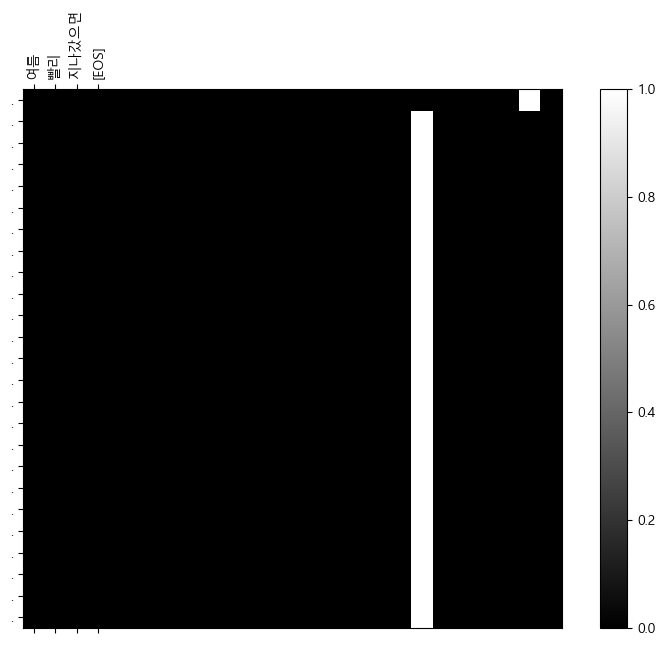

In [277]:
idx = 2100
evaluate_and_show_attention(encoder, decoder, dataset[idx][0], dataset, device)